# Elliptical Data

Exploring (hopefully) more tractable non-Gaussian distributions.

In [1]:
import jax
from localization import datasets
import matplotlib.pyplot as plt
from localization.utils import build_gaussian_covariance

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=5,
  xi2=5,
  df=5,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # experiment config
  seed=0,
)

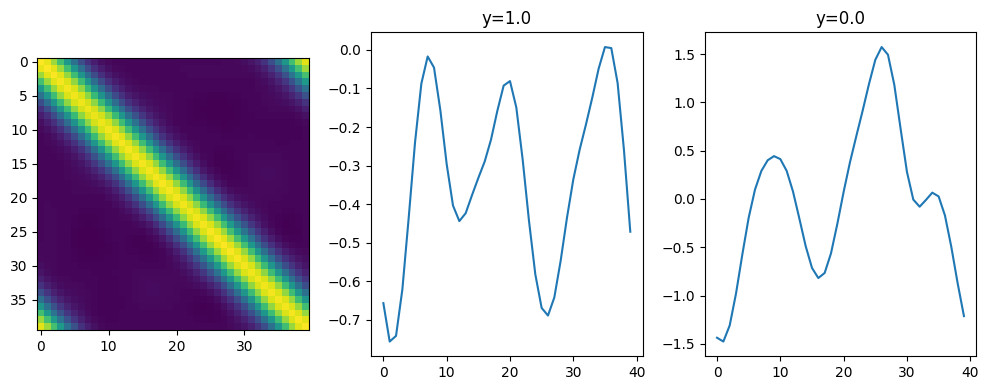

In [2]:
dataset = datasets.TDataset(key=jax.random.PRNGKey(0), **config_, num_exemplars=100000)
x, y = dataset[:100000]
xx = x.T @ x / len(x)
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(xx)
axs[1].plot(x[0])
axs[1].set_title(f'y={y[0]}')
axs[2].plot(x[1])
axs[2].set_title(f'y={y[1]}')
fig.tight_layout()

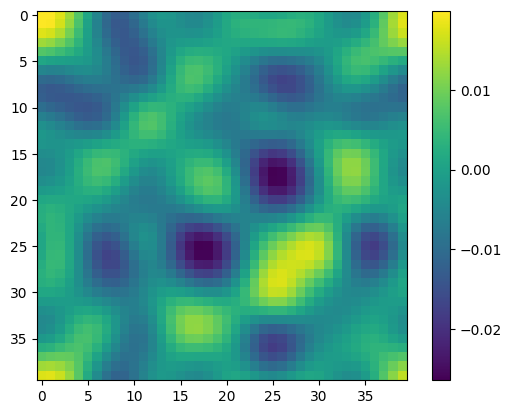

In [3]:
im = plt.imshow(xx - build_gaussian_covariance(40, 5))
plt.colorbar(im)

### Learning from t-data

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.TDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

In [4]:
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=1, num_epochs=10000, 
    df=5,
    # gain=3, 
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights[::10], num_cols=11, evaluation_interval=1000, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)
# fig, axs = plot_rf_evolution(weights, cmap='gray', figsize=(10, 5))

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 1000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.multi_t.TDataset'>,
 'df': 5,
 'evaluation_interval': 100,
 'gain': None,
 'init_fn': <function xavier_normal_init at 0x14f7f2520>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 1,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 10000,
 'num_hiddens': 40,
 'optimizer_fn': <function sgd at 0x1308bf420>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 10000000
Length of eval dataset: 1000
Length of train sampler: 10000000
Length of eval sampler: 1000


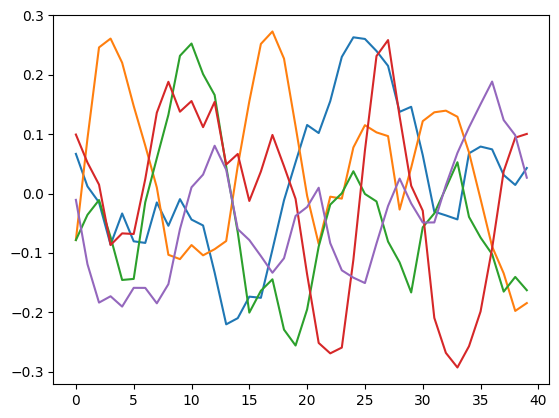

In [3]:
_ = plt.plot(weights[-1,:5].T)

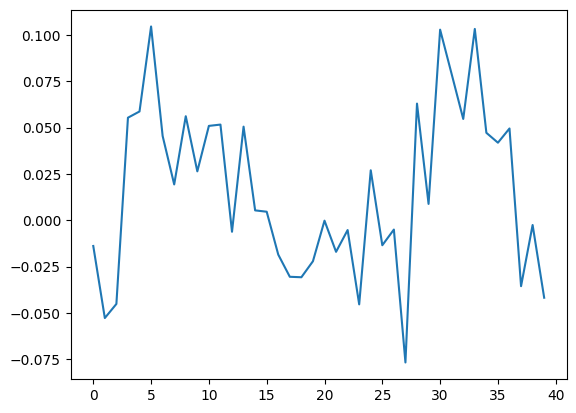

In [21]:
_ = plt.plot(weights[1,0])

In [21]:
weights[5,0]

array([ 0.03806078, -0.00640856, -0.01530846,  0.07371872,  0.00938829,
        0.08136344, -0.03610664, -0.05248559,  0.07087168, -0.04579896,
       -0.01423462,  0.02909311, -0.09117647,  0.07759472,  0.01522831,
        0.00924608,  0.02950739, -0.00941721, -0.03372172,  0.01579539,
       -0.04932225,  0.05721361, -0.02128004, -0.05984038,  0.03204441,
       -0.01404464,  0.02255496, -0.09093183,  0.09907813, -0.07155968,
        0.03930189,  0.15226614,  0.19591127,  0.20770435,  0.06101864,
        0.00239856,  0.0160922 , -0.06115257,  0.03246481, -0.05865391],
      dtype=float32)